**Autoencoders and GANs**

This notebook is inspired by https://github.com/ageron/handson-ml2

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
#This segment verifies the setup
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"



# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

IS_COLAB=0
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. CNNs can be very slow without a GPU.


In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# PCA with a linear Autoencoder

Build 3D dataset:

In [5]:
m= 10
noise=0.1
angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2

array([ 0.75439978, -1.01325399, -0.90928024, -0.33941898,  1.1010898 ,
        0.9932989 ,  0.7760796 , -1.14584015, -0.37916691, -0.78808185])

In [6]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [7]:
X_train.shape, X_train.ndim

((60, 3), 2)

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3]), ])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.1))

/usr/local/anaconda/envs/tensorflow2/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [9]:
history = autoencoder.fit(X_train, X_train, epochs=200)

Epoch 1/200
2/2 [==============================] - 0s 3ms/step - loss: 0.3019
Epoch 2/200
2/2 [==============================] - 0s 2ms/step - loss: 0.2836
Epoch 3/200
2/2 [==============================] - 0s 2ms/step - loss: 0.2667
Epoch 4/200
2/2 [==============================] - 0s 2ms/step - loss: 0.2520
Epoch 5/200
2/2 [==============================] - 0s 2ms/step - loss: 0.2370
Epoch 6/200
2/2 [==============================] - 0s 2ms/step - loss: 0.2234
Epoch 7/200
2/2 [==============================] - 0s 2ms/step - loss: 0.2098
Epoch 8/200
2/2 [==============================] - 0s 2ms/step - loss: 0.1968
Epoch 9/200
2/2 [==============================] - 0s 2ms/step - loss: 0.1843
Epoch 10/200
2/2 [==============================] - 0s 2ms/step - loss: 0.1722
Epoch 11/200
2/2 [==============================] - 0s 2ms/step - loss: 0.1605
Epoch 12/200
2/2 [==============================] - 0s 2ms/step - loss: 0.1498
Epoch 13/200
2/2 [==============================] - 0s 2ms/st

In [10]:
codings = encoder.predict(X_train)

Saving figure linear_autoencoder_pca_plot


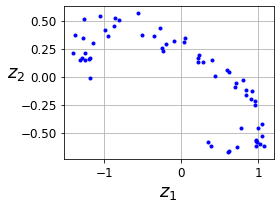

In [11]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# Stacked Autoencoders

Let's use MNIST:

In [9]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

## Train all layers at once

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [37]:
keras.metrics.binary_accuracy?

In [12]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3166 - val_rounded_accuracy: 0.9002
Epoch 2/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9201
Epoch 3/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2985 - val_rounded_accuracy: 0.9200
Epoch 4/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2937 - val_rounded_accuracy: 0.9285
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9284
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2915 - val_rounded_accuracy: 0.9305
Epoch 7/20
1719/1719 [==================

In [16]:
history1 = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2811 - rounded_accuracy: 0.9368 - val_loss: 0.2837 - val_rounded_accuracy: 0.9342
Epoch 2/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2808 - rounded_accuracy: 0.9369 - val_loss: 0.2836 - val_rounded_accuracy: 0.9368
Epoch 3/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2805 - rounded_accuracy: 0.9372 - val_loss: 0.2859 - val_rounded_accuracy: 0.9294
Epoch 4/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2803 - rounded_accuracy: 0.9374 - val_loss: 0.2815 - val_rounded_accuracy: 0.9372
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2801 - rounded_accuracy: 0.9375 - val_loss: 0.2817 - val_rounded_accuracy: 0.9367
Epoch 6/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2799 - rounded_accuracy: 0.9377 - val_loss: 0.2816 - val_rounded_accuracy: 0.9381
Epoch 7/20
1719/1719 [==================

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

In [17]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Saving figure reconstruction_plot


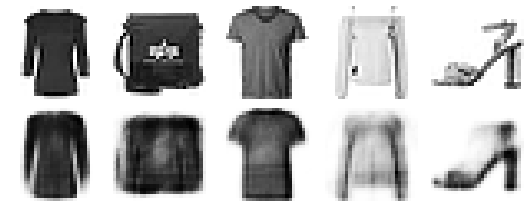

In [18]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

## Visualizing Fashion MNIST

In [19]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

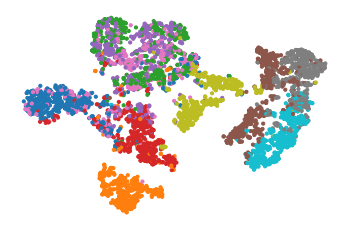

In [20]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

Saving figure fashion_mnist_visualization_plot


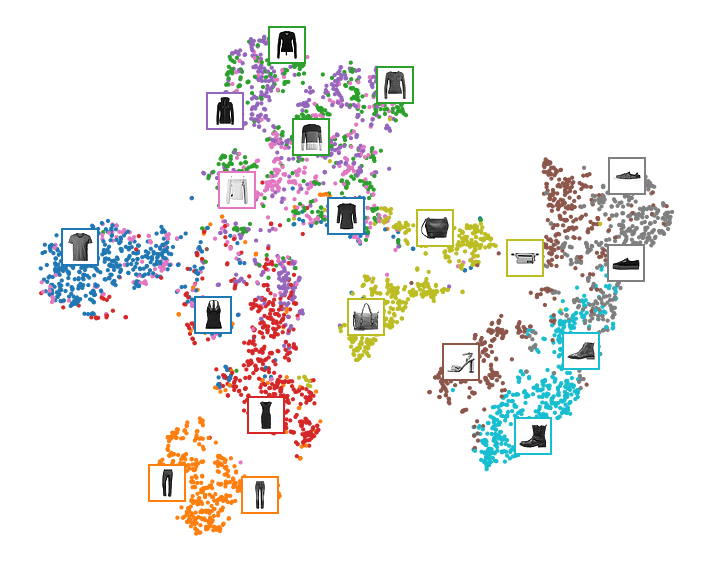

In [46]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

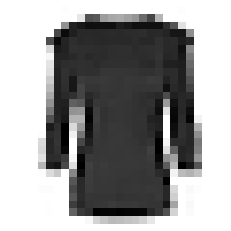

In [27]:
plot_image(X_valid[0])

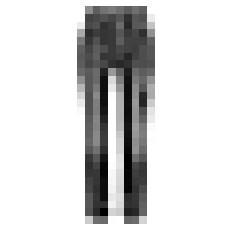

In [28]:
plot_image(X_valid[22])

In [29]:
# 
# 

X_valid_compressed_0 = stacked_encoder.predict(np.array([X_valid[0]]))

In [30]:
X_valid_compressed_22 = stacked_encoder.predict(np.array([X_valid[22]]))

In [23]:
X_valid_compressed_0, X_valid_compressed_22

(array([[-1.7578213, -1.1027168,  3.9865272, -1.7580956, -0.9727   ,
          5.0061545,  0.5948099,  2.7915058,  9.54521  , 11.080704 ,
          5.8128366, 11.715912 ,  8.040677 ,  6.6796827, 16.161955 ,
          4.973403 , -1.7580583,  4.4884357,  7.43497  , -1.7580597,
          6.4410315,  2.320041 , -1.7580247, -1.6718444, -1.7580895,
          0.5258758,  2.854575 , -1.7578944, -1.7577955,  3.6821566]],
       dtype=float32),
 array([[-1.7500718 , 21.069485  ,  2.893178  , -1.7306271 , -0.8011496 ,
          1.0220797 ,  1.8962542 ,  0.60900635,  6.5934134 ,  1.5939256 ,
          0.11382739, -0.31927288,  9.35359   , 14.545134  ,  5.1812153 ,
          7.2682953 , -1.7289219 ,  0.02159232, -1.027319  , -1.7321373 ,
          0.6671262 ,  7.6978893 , -1.7208724 , -1.7133596 , -1.7383889 ,
          7.019285  ,  8.604409  , -1.721731  , -1.7201837 ,  4.4279556 ]],
       dtype=float32))

In [41]:
codings = (X_valid_compressed_0 + 1.5*X_valid_compressed_22)/2

In [42]:
result = stacked_decoder.predict(codings)

In [43]:
img_0_22 = result[0]

In [44]:
img_0_22

array([[1.44510075e-08, 7.47072306e-08, 6.95140372e-08, 1.67902317e-06,
        4.07279185e-05, 4.77869435e-05, 4.95645254e-05, 5.04404306e-04,
        8.39799643e-04, 1.12924576e-02, 1.54428333e-01, 4.64571595e-01,
        6.36399984e-01, 5.76087475e-01, 5.56796372e-01, 5.98674178e-01,
        6.06699705e-01, 3.10025752e-01, 5.99445105e-02, 4.98175621e-03,
        7.30305910e-04, 9.05811787e-04, 4.43845987e-04, 7.05806233e-05,
        1.38338677e-07, 1.32300306e-06, 1.92619023e-08, 8.19733081e-09],
       [1.20300863e-08, 6.43819753e-09, 1.31138966e-08, 7.70810473e-08,
        1.81162177e-05, 8.48919171e-06, 3.48082722e-05, 4.29213047e-04,
        1.62622631e-02, 1.79302931e-01, 5.40529430e-01, 7.22986937e-01,
        7.30284691e-01, 6.81086719e-01, 6.21029019e-01, 5.54202139e-01,
        6.89715385e-01, 6.02449358e-01, 3.09846401e-01, 8.23099315e-02,
        3.14083695e-03, 5.25891781e-04, 2.04831362e-04, 3.18065067e-05,
        1.22253326e-07, 2.49489052e-09, 5.07641085e-09, 5.76153

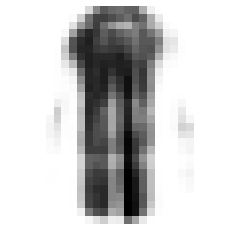

In [45]:
plot_image(img_0_22)

## Tying weights

It is common to tie the weights of the encoder and the decoder, by simply using the transpose of the encoder's weights as the decoder weights. For this, we need to use a custom layer.

In [16]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 14s 262us/sample - loss: 0.3268 - rounded_accuracy: 0.8960 - val_loss: 0.3024 - val_rounded_accuracy: 0.9207
Epoch 2/10
55000/55000 [==============================] - 12s 219us/sample - loss: 0.2974 - rounded_accuracy: 0.9225 - val_loss: 0.2974 - val_rounded_accuracy: 0.9271
Epoch 3/10
55000/55000 [==============================] - 12s 215us/sample - loss: 0.2918 - rounded_accuracy: 0.9277 - val_loss: 0.2961 - val_rounded_accuracy: 0.9265
Epoch 4/10
55000/55000 [==============================] - 12s 220us/sample - loss: 0.2889 - rounded_accuracy: 0.9303 - val_loss: 0.2899 - val_rounded_accuracy: 0.9321
Epoch 5/10
55000/55000 [==============================] - 12s 214us/sample - loss: 0.2867 - rounded_accuracy: 0.9322 - val_loss: 0.2867 - val_rounded_accuracy: 0.9338
Epoch 6/10
55000/55000 [==============================] - 12s 219us/sample - loss: 0.2851 - rounded_accuracy: 0.9337

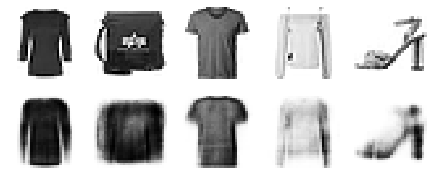

In [18]:
show_reconstructions(tied_ae)
plt.show()

## Training one Autoencoder at a Time

In [19]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(lr=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(lr=0.05),
    output_activation="selu")

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 10s 189us/sample - loss: 0.3446 - rounded_accuracy: 0.8873 - val_loss: 0.3123 - val_rounded_accuracy: 0.9148
Epoch 2/10
55000/55000 [==============================] - 10s 181us/sample - loss: 0.3040 - rounded_accuracy: 0.9202 - val_loss: 0.3008 - val_rounded_accuracy: 0.9248
Epoch 3/10
55000/55000 [==============================] - 10s 186us/sample - loss: 0.2951 - rounded_accuracy: 0.9284 - val_loss: 0.2936 - val_rounded_accuracy: 0.9314
Epoch 4/10
55000/55000 [==============================] - 10s 187us/sample - loss: 0.2893 - rounded_accuracy: 0.9340 - val_loss: 0.2889 - val_rounded_accuracy: 0.9357
Epoch 5/10
55000/55000 [==============================] - 10s 190us/sample - loss: 0.2855 - rounded_accuracy: 0.9376 - val_loss: 0.2859 - val_rounded_accuracy: 0.9387
Epoch 6/10
55000/55000 [==============================] - 10s 178us/sample - loss: 0.2829 - rounded_accuracy: 0.9401

In [21]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

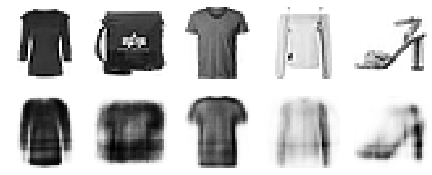

In [22]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [23]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(lr=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 12s 227us/sample - loss: 0.2847 - rounded_accuracy: 0.9366 - val_loss: 0.2863 - val_rounded_accuracy: 0.9366
Epoch 2/10
55000/55000 [==============================] - 12s 224us/sample - loss: 0.2844 - rounded_accuracy: 0.9369 - val_loss: 0.2861 - val_rounded_accuracy: 0.9369
Epoch 3/10
55000/55000 [==============================] - 13s 231us/sample - loss: 0.2842 - rounded_accuracy: 0.9371 - val_loss: 0.2859 - val_rounded_accuracy: 0.9370
Epoch 4/10
55000/55000 [==============================] - 12s 222us/sample - loss: 0.2840 - rounded_accuracy: 0.9373 - val_loss: 0.2858 - val_rounded_accuracy: 0.9370
Epoch 5/10
55000/55000 [==============================] - 11s 209us/sample - loss: 0.2839 - rounded_accuracy: 0.9374 - val_loss: 0.2857 - val_rounded_accuracy: 0.9373
Epoch 6/10
55000/55000 [==============================] - 12s 215us/sample - loss: 0.2838 - rounded_accuracy: 0.9375

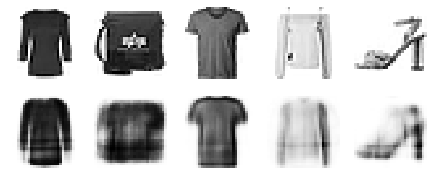

In [24]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

# Using Convolutional Layers Instead of Dense Layers

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [25]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 38s 685us/sample - loss: 0.3018 - rounded_accuracy: 0.9183 - val_loss: 0.2798 - val_rounded_accuracy: 0.9390
Epoch 2/5
55000/55000 [==============================] - 35s 638us/sample - loss: 0.2755 - rounded_accuracy: 0.9412 - val_loss: 0.2760 - val_rounded_accuracy: 0.9429
Epoch 3/5
55000/55000 [==============================] - 35s 643us/sample - loss: 0.2707 - rounded_accuracy: 0.9463 - val_loss: 0.2730 - val_rounded_accuracy: 0.9447
Epoch 4/5
55000/55000 [==============================] - 35s 631us/sample - loss: 0.2681 - rounded_accuracy: 0.9490 - val_loss: 0.2677 - val_rounded_accuracy: 0.9512
Epoch 5/5
55000/55000 [==============================] - 35s 643us/sample - loss: 0.2663 - rounded_accuracy: 0.9508 - val_loss: 0.2665 - val_rounded_accuracy: 0.9525


In [26]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)        

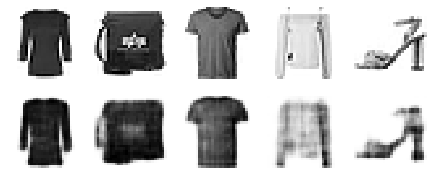

In [27]:
show_reconstructions(conv_ae)
plt.show()

# Recurrent Autoencoders

In [28]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [29]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 177s 3ms/sample - loss: 0.5191 - rounded_accuracy: 0.7484 - val_loss: 0.4583 - val_rounded_accuracy: 0.8129
Epoch 2/10
55000/55000 [==============================] - 169s 3ms/sample - loss: 0.4053 - rounded_accuracy: 0.8431 - val_loss: 0.3740 - val_rounded_accuracy: 0.8664
Epoch 3/10
55000/55000 [==============================] - 169s 3ms/sample - loss: 0.3656 - rounded_accuracy: 0.8708 - val_loss: 0.3583 - val_rounded_accuracy: 0.8788
Epoch 4/10
55000/55000 [==============================] - 173s 3ms/sample - loss: 0.3511 - rounded_accuracy: 0.8805 - val_loss: 0.3450 - val_rounded_accuracy: 0.8860
Epoch 5/10
55000/55000 [==============================] - 172s 3ms/sample - loss: 0.3406 - rounded_accuracy: 0.8873 - val_loss: 0.3376 - val_rounded_accuracy: 0.8867
Epoch 6/10
55000/55000 [==============================] - 171s 3ms/sample - loss: 0.3335 - rounded_accuracy: 0.8922 - val

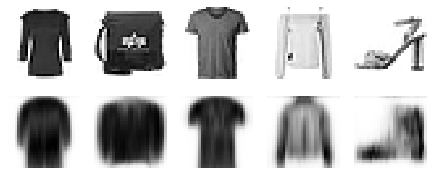

In [30]:
show_reconstructions(recurrent_ae)
plt.show()

# Stacked denoising Autoencoder

Using Gaussian noise:

In [31]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 14s 256us/sample - loss: 0.3513 - rounded_accuracy: 0.8763 - val_loss: 0.3179 - val_rounded_accuracy: 0.9066
Epoch 2/10
55000/55000 [==============================] - 13s 245us/sample - loss: 0.3126 - rounded_accuracy: 0.9093 - val_loss: 0.3078 - val_rounded_accuracy: 0.9165
Epoch 3/10
55000/55000 [==============================] - 13s 234us/sample - loss: 0.3058 - rounded_accuracy: 0.9150 - val_loss: 0.3030 - val_rounded_accuracy: 0.9191
Epoch 4/10
55000/55000 [==============================] - 14s 247us/sample - loss: 0.3021 - rounded_accuracy: 0.9183 - val_loss: 0.2999 - val_rounded_accuracy: 0.9232
Epoch 5/10
55000/55000 [==============================] - 13s 236us/sample - loss: 0.2991 - rounded_accuracy: 0.9209 - val_loss: 0.2969 - val_rounded_accuracy: 0.9253
Epoch 6/10
55000/55000 [==============================] - 13s 234us/sample - loss: 0.2968 - rounded_accuracy: 0.9230

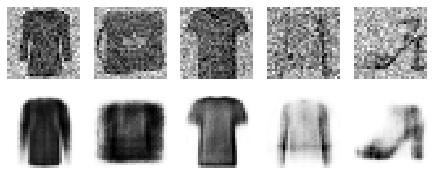

In [32]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

Using dropout:

In [33]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 14s 257us/sample - loss: 0.3572 - rounded_accuracy: 0.8703 - val_loss: 0.3193 - val_rounded_accuracy: 0.9052
Epoch 2/10
55000/55000 [==============================] - 13s 244us/sample - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3117 - val_rounded_accuracy: 0.9115
Epoch 3/10
55000/55000 [==============================] - 14s 264us/sample - loss: 0.3128 - rounded_accuracy: 0.9076 - val_loss: 0.3087 - val_rounded_accuracy: 0.9144
Epoch 4/10
55000/55000 [==============================] - 14s 249us/sample - loss: 0.3096 - rounded_accuracy: 0.9100 - val_loss: 0.3049 - val_rounded_accuracy: 0.9164
Epoch 5/10
55000/55000 [==============================] - 14s 251us/sample - loss: 0.3070 - rounded_accuracy: 0.9120 - val_loss: 0.3023 - val_rounded_accuracy: 0.9178
Epoch 6/10
55000/55000 [==============================] - 14s 261us/sample - loss: 0.3052 - rounded_accuracy: 0.9134

Saving figure dropout_denoising_plot


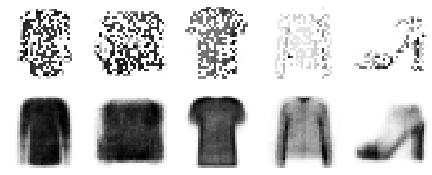

In [34]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

# Sparse Autoencoder

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 14s 251us/sample - loss: 0.4332 - rounded_accuracy: 0.7944 - val_loss: 0.3777 - val_rounded_accuracy: 0.8503
Epoch 2/10
55000/55000 [==============================] - 12s 220us/sample - loss: 0.3614 - rounded_accuracy: 0.8667 - val_loss: 0.3511 - val_rounded_accuracy: 0.8786
Epoch 3/10
55000/55000 [==============================] - 13s 229us/sample - loss: 0.3403 - rounded_accuracy: 0.8860 - val_loss: 0.3360 - val_rounded_accuracy: 0.8896
Epoch 4/10
55000/55000 [==============================] - 12s 221us/sample - loss: 0.3280 - rounded_accuracy: 0.8962 - val_loss: 0.3256 - val_rounded_accuracy: 0.9006
Epoch 5/10
55000/55000 [==============================] - 12s 223us/sample - loss: 0.3213 - rounded_accuracy: 0.9012 - val_loss: 0.3215 - val_rounded_accuracy: 0.9016
Epoch 6/10
55000/55000 [==============================] - 12s 223us/sample - loss: 0.3178 - rounded_accuracy: 0.9037

In [ ]:
show_reconstructions(simple_ae)
plt.show()

Let's create a couple functions to print nice activation histograms:

In [9]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [10]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

Let's use these functions to plot histograms of the activations of the encoding layer.

In [11]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

NameError: name 'simple_encoder' is not defined

Now let's add $\ell_1$ regularization to the coding layer:

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

/usr/local/anaconda/envs/tensorflow2/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


NameError: name 'rounded_accuracy' is not defined

In [13]:
show_reconstructions(sparse_l1_ae)

NameError: name 'show_reconstructions' is not defined

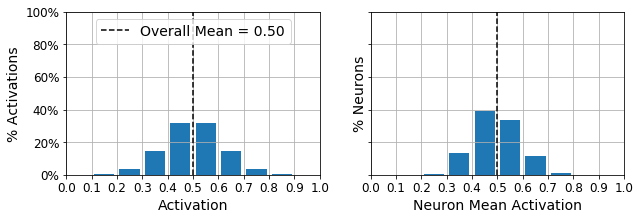

In [14]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

Let's use the KL Divergence loss instead to ensure sparsity, and target 10% sparsity rather than 0%:

Saving figure sparsity_loss_plot


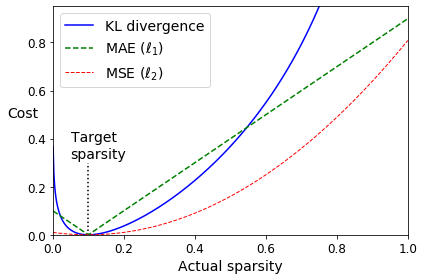

In [15]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [16]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [17]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

/usr/local/anaconda/envs/tensorflow2/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


NameError: name 'rounded_accuracy' is not defined

In [ ]:
show_reconstructions(sparse_kl_ae)

In [ ]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show()

# Variational Autoencoder

In [ ]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

In [ ]:
show_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images

In [53]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Let's generate a few random codings, decode them and plot the resulting images:

In [54]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

NameError: name 'variational_decoder' is not defined

Now let's perform semantic interpolation between these images:

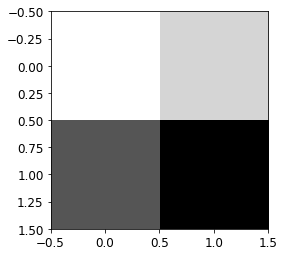

In [66]:
plt.imshow([[0.1, 0.2],[0.5, 0.7]], cmap="binary")

In [56]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

NameError: name 'variational_decoder' is not defined

# Generative Adversarial Networks

In [57]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28*3, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [58]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [59]:
X_train.shape


(55000, 28, 28)

In [60]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [15]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              
        for i in range(2):
            for X_batch in dataset:
                # phase 1 - training the discriminator
                noise = tf.random.normal(shape=[batch_size, codings_size])
                generated_images = generator(noise) # batchsize x 28 x 28
                X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
                y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
                discriminator.trainable = True
                discriminator.train_on_batch(X_fake_and_real, y1)

        for i in range(2):
            for X_batch in dataset:
                # phase 2 - training the generator
                noise = tf.random.normal(shape=[batch_size, codings_size])
                y2 = tf.constant([[1.]] * batch_size)
                discriminator.trainable = False
                gan.train_on_batch(noise, y2)

        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown

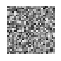

In [62]:
generated_images = generator(np.array([[0.1,0.3,0 , 0, 0, 0,0.1,0.3,0 , 0, 0, 0,0.1,0.3,0 , 0, 0, 0,0.1,0.3,0 , 0, 0, 0,0,0,1,1,1,1]])) # batchsize x 28 x 28
plot_multiple_images(generated_images, 8) 

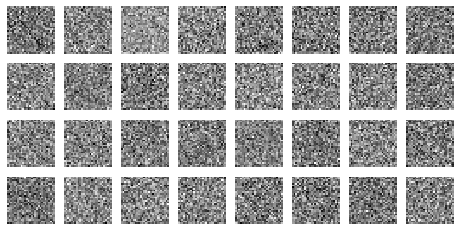

In [63]:
generator, discriminator = gan.layers
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise) # batchsize x 28 x 28
plot_multiple_images(generated_images, 8) 

In [65]:
generated_images[0]

<tf.Tensor: shape=(28, 28), dtype=float32, numpy=
array([[0.47804958, 0.56955445, 0.42836738, 0.40189493, 0.59918505,
        0.3701555 , 0.49153316, 0.36714932, 0.47870004, 0.5172264 ,
        0.27182418, 0.6025711 , 0.6188209 , 0.27230167, 0.591265  ,
        0.6028977 , 0.5250085 , 0.4571895 , 0.59683645, 0.28696877,
        0.36419666, 0.44447303, 0.51101243, 0.51022124, 0.42820102,
        0.48695135, 0.4907288 , 0.348316  ],
       [0.5131784 , 0.5864121 , 0.5161278 , 0.33884647, 0.41608843,
        0.5775847 , 0.4816626 , 0.5155775 , 0.6513834 , 0.5071916 ,
        0.34718773, 0.4672641 , 0.50565445, 0.5035768 , 0.6370473 ,
        0.58982426, 0.62280035, 0.38308093, 0.6366166 , 0.5925591 ,
        0.41289788, 0.42675096, 0.49864438, 0.2663135 , 0.5443051 ,
        0.5204305 , 0.57942736, 0.31319016],
       [0.5790992 , 0.44796014, 0.49736577, 0.6010623 , 0.45658192,
        0.45668665, 0.536946  , 0.42877033, 0.42509755, 0.6079483 ,
        0.43876228, 0.46972817, 0.5882107 , 

Epoch 1/10


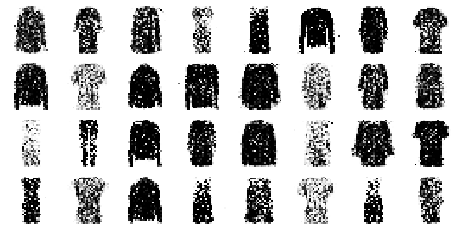

Epoch 2/10


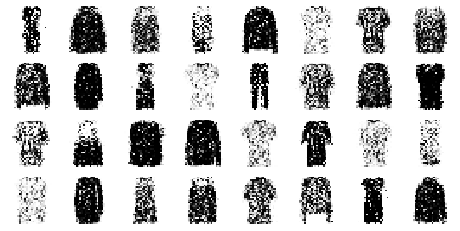

Epoch 3/10


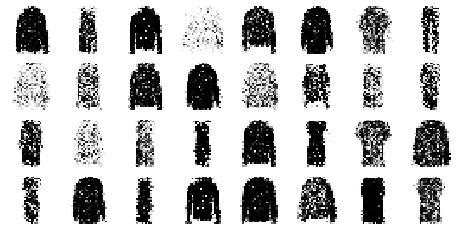

Epoch 4/10


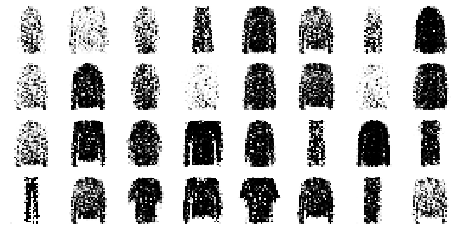

Epoch 5/10


KeyboardInterrupt: 

In [36]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)

In [ ]:
train_gan(gan, dataset, batch_size, codings_size)

# Deep Convolutional GAN

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [11]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [12]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [13]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [16]:
train_gan(gan, dataset, batch_size, codings_size)

Epoch 1/50


NameError: name 'plot_multiple_images' is not defined

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)